# **Final Stacking Model**

* Input files: prepared_data2.csv, catboost_precision.joblib, best_tabnet.zip

In [1]:
import joblib
from pytorch_tabnet.tab_model import TabNetClassifier
from catboost import CatBoostClassifier

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('prepared_data2.csv')

# Define independent (X) and dependent (y) variables
X = df.drop(columns=['Target'])  # Drop the target column
y = df['Target']  # Target variable

# Stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, stratify=y, shuffle=True, random_state=42)

* Load model trained by model_tabnet.ipynb and xgb_catboost.ipynb

In [5]:
# Load CatBoost model
catboost_model = joblib.load("catboost_precision.joblib")

# Load TabNet model
tabnet_model = TabNetClassifier()
tabnet_model.load_model("best_tabnet.zip")

c:\Users\Arial\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
c:\Users\Arial\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:454: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full c

* Get predictions from both models and stack the results using Logistic regression

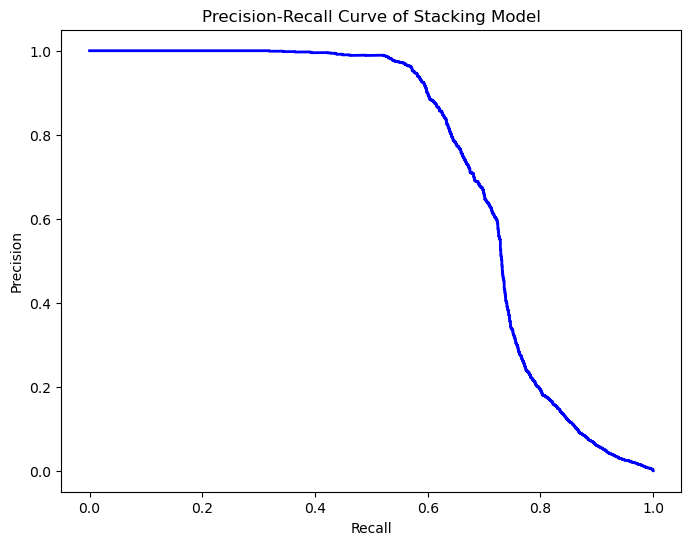

In [ ]:
# Get predictions (probabilities)
tabnet_preds = tabnet_model.predict_proba(X_test.values)[:, 1]
catboost_preds = catboost_model.predict_proba(X_test.values)[:, 1]

# Stack the predictions as new features
X_meta = np.column_stack((tabnet_preds, catboost_preds))

# Train meta-learner using validation data
meta_model = LogisticRegression()
meta_model.fit(X_meta, y_test.values)

# Get final stacked predictions
meta_preds_proba = meta_model.predict_proba(X_meta)[:, 1]
meta_preds = (meta_preds_proba > 0.5).astype(int)

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, meta_preds_proba)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve of Stacking Model')
plt.show()

* Evaluate the model using precision, recall, and f1 score of class 1 (Fraud), and tune the decision threshold based on f1 score

In [10]:
# Calculate F1 scores for different thresholds
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the best threshold based on F1 score
best_threshold = thresholds[f1_scores.argmax()]

# Print the best threshold
print("Best Threshold:", best_threshold)

# Apply the best threshold for classification
meta_pred_adj = (meta_preds_proba >= best_threshold).astype(int)

# Evaluate the performance
print(classification_report(y_test.values, meta_pred_adj))
print("Average Precision Score:", average_precision_score(y_test.values, meta_preds_proba))

Best Threshold: 0.6883243101456739
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.92      0.59      0.72      2666

    accuracy                           1.00   1782993
   macro avg       0.96      0.80      0.86   1782993
weighted avg       1.00      1.00      1.00   1782993

Average Precision Score: 0.7280420369880898


* Check the the two models' importance for the meta model

In [11]:
coeffs = pd.DataFrame(meta_model.coef_, columns=["TabNet", "CatBoost"], index=["coeff"])
coeffs

,TabNet,CatBoost
coeff,6.302659,10.662622
